# Ross Sea synthetic gravity inversion ensembles

Here we test the effects of the constraint spacing and the gravity data resolution by running the inversion with an ensemble of different values.

import packages

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting, optimization, synthetic, regional
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import geopandas as gpd
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import os
import pathlib
import string
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
import string
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.contrib.itertools import product
from tqdm.autonotebook import tqdm

sns.set_theme()

# Load data

## topographic layers
* full resolution bed 
* low resolution bed

In [3]:
bed = xr.open_zarr("../../synthetic_data/Ross_Sea_bed.zarr").z

starting_bed = xr.open_zarr("../../synthetic_data/Ross_Sea_lowres_bed_semiregular.zarr").z

# ensure all xarray are same data type
bed = bed.astype(np.float64)
starting_bed = starting_bed.astype(np.float64)

print(utils.get_grid_info(bed))
print(utils.get_grid_info(starting_bed))
starting_bed

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(5000.0, [-80000.0, 300000.0, -1840000.0, -1360000.0], -968.675476074, -168.314071655, 'g')
(5000.0, [-80000.0, 300000.0, -1840000.0, -1360000.0], -969.619506836, -164.541534424, 'g')


<xarray.DataArray 'z' (northing: 97, easting: 77)>
dask.array<open_dataset-7b8eea31923f7d4997f7318b5e4fac15z, shape=(97, 77), dtype=float64, chunksize=(97, 77), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 -8e+04 -7.5e+04 -7e+04 ... 2.95e+05 3e+05
  * northing  (northing) float64 -1.84e+06 -1.835e+06 ... -1.365e+06 -1.36e+06
Attributes:
    metadata:  Generated by SplineCV(dampings=[1e-20, 3.162277660168379e-13, ...

# Set region and parameters

Use the same regions and parameters as `Ross_Sea synthetic_model.ipynb`

In [4]:
layer_spacing, buffer_region, _, _, registration = utils.get_grid_info(bed)

# set gravity observation parameters
grav_spacing = layer_spacing

inversion_region = vd.pad_region(buffer_region, pad=-40e3)

# set density contrast
density = 2300 - 1024
# density = 2500 - 1024

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

layer spacing: 5000.0m
registration: g
inversion region =  (-40000.0, 260000.0, -1800000.0, -1400000.0)
buffer region =  [-80000.0, 300000.0, -1840000.0, -1360000.0]


## constraint points

In [5]:
# load constraint points into a dataframe
constraints_all = pd.read_csv(
    "../../synthetic_data/Ross_Sea_synthetic_constraints_semiregular.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraints = utils.points_inside_region(
    constraints_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraints)}")
constraints.head()

bathymetry control points:1014


,northing,easting,inside,upward,uncert
624,-1800000.0,-40000.0,False,-459.983720,5.0
625,-1800000.0,-35000.0,False,-441.729016,5.0
626,-1800000.0,-30000.0,False,-423.061710,5.0
627,-1800000.0,-25000.0,False,-404.248569,5.0
628,-1800000.0,-20000.0,False,-401.593575,5.0


# Misfit

In [6]:
grav_df = pd.read_csv(
    "../../synthetic_data/Ross_Sea_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav_df

,northing,easting,basement,bathymetry,Gobs,test,upward,bed_forward,Gobs_shift,misfit
0,-1800000.0,-40000.0,10.954490,1.539214,12.493704,False,1000.0,1.588803,6.559877,4.971074
1,-1800000.0,-37500.0,11.301743,2.179182,13.480925,True,1000.0,2.189981,7.547098,5.357117
2,-1800000.0,-35000.0,11.628426,2.738309,14.366735,False,1000.0,2.731633,8.432908,5.701275
3,-1800000.0,-32500.0,11.926100,3.121790,15.047890,True,1000.0,3.225948,9.114063,5.888115
4,-1800000.0,-30000.0,12.197463,3.460530,15.657992,False,1000.0,3.687668,9.724166,6.036497
...,...,...,...,...,...,...,...,...,...,...
19476,-1400000.0,250000.0,-4.359605,-16.596796,-20.956401,False,1000.0,-16.379783,-26.890228,-10.510445
19477,-1400000.0,252500.0,-5.283528,-16.946833,-22.230361,True,1000.0,-16.835889,-28.164188,-11.328299
19478,-1400000.0,255000.0,-6.260088,-17.317246,-23.577334,False,1000.0,-17.321311,-29.511161,-12.189849
19479,-1400000.0,257500.0,-7.275874,-17.744627,-25.020501,True,1000.0,-17.722308,-30.954328,-13.232020


In [7]:
df_anomalies = pd.read_csv(
    "../../synthetic_data/Ross_Sea_gravity_anomalies.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# Constraints grid

In [8]:
starting_prisms = xr.open_zarr(
    "../../inversion_layers/Ross_Sea_starting_prisms.zarr",
)

# Ensemble of noise levels and cell sizes

In [51]:
full_res_grav_grid = (
    grav_df[grav_df.test == False].set_index(["northing", "easting"]).to_xarray()
)
full_res_grav_grid

<xarray.Dataset>
Dimensions:      (northing: 81, easting: 61)
Coordinates:
  * northing     (northing) float64 -1.8e+06 -1.795e+06 ... -1.405e+06 -1.4e+06
  * easting      (easting) float64 -4e+04 -3.5e+04 -3e+04 ... 2.55e+05 2.6e+05
Data variables:
    basement     (northing, easting) float64 10.95 11.63 12.2 ... -6.26 -8.327
    bathymetry   (northing, easting) float64 1.539 2.738 3.461 ... -17.32 -18.19
    Gobs         (northing, easting) float64 12.49 14.37 15.66 ... -23.58 -26.51
    test         (northing, easting) bool False False False ... False False
    upward       (northing, easting) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03
    bed_forward  (northing, easting) float64 1.589 2.732 3.688 ... -17.32 -18.11
    Gobs_shift   (northing, easting) float64 6.56 8.433 9.724 ... -29.51 -32.45
    misfit       (northing, easting) float64 4.971 5.701 6.036 ... -12.19 -14.33

In [52]:
def synthetic_survey(
    region,
    ew_spacing,
    ns_spacing,
    ew_to_remove=None,
    ns_to_remove=None,
    observation_height=1e3,
    along_line_spacing=1e3,
    offset=7e3,
):
    # irregular grid
    # simulate N-S tie lines
    x = np.arange(inversion_region[0] + offset, inversion_region[1], ns_spacing)
    y = np.arange(inversion_region[2], inversion_region[3], along_line_spacing)

    # remove the 3rd and 9th N-S lines
    if ew_to_remove is not None:
        x = np.delete(x, ew_to_remove)

    coords = np.meshgrid(x, y)
    # turn coordinates into dataarray
    ties = vd.make_xarray_grid(
        coords,
        data=np.ones_like(coords[0]) * observation_height,
        data_names="upward",
        dims=("northing", "easting"),
    )
    # turn dataarray into dataframe
    df_ties = vd.grid_to_table(ties)

    # simulate E-W flight lines
    x = np.arange(region[0], region[1], along_line_spacing)
    y = np.arange(region[2] + offset, region[3], ew_spacing)

    # remove a few E-W lines, starting from bottom
    if ns_to_remove is not None:
        y = np.delete(y, ns_to_remove)

    coords = np.meshgrid(x, y)
    # turn coordinates into dataarray
    lines = vd.make_xarray_grid(
        coords,
        data=np.ones_like(coords[0]) * observation_height,
        data_names="upward",
        dims=("northing", "easting"),
    )
    # turn dataarray into dataframe
    df_lines = vd.grid_to_table(lines)

    # merge dataframes
    df = pd.concat([df_ties, df_lines])

    return df

In [ ]:
# spacings = [60e3, 80e3]
# noise_levels = [0, .09] # decimal percent gaussian noise

noise_levels = [0, .01, .02, .03, .04, .05, .06, .07, .08, .09] # decimal percent gaussian noise
spacings = [10e3, 20e3, 30e3, 40e3, 50e3, 60e3, 70e3, 80e3, 90e3, 100e3]

param_coords = []
eq_scores = []
anom_dfs = []
survey_dfs = []
for (n,s) in product(noise_levels, spacings, desc="Noise/Spacing"):
    param_coords.append([n,s])

    survey = synthetic_survey(
        inversion_region,
        ew_spacing=s,
        ns_spacing=s,
        ew_to_remove=None,
        ns_to_remove=None,
        observation_height = 1e3,
        along_line_spacing = 5e3,
        offset = 7e3,
    )
    # sample the data at the observation points
    grav_survey = profile.sample_grids(
        survey, full_res_grav_grid.Gobs, "Gobs", coord_names=("easting", "northing")
    )

    coords = (grav_survey.easting, grav_survey.northing, grav_survey.upward)
    data = grav_survey.Gobs

    dampings = [10**-5, 10**1]
    depths = [1e3, 100e3]

    study_df, eqs = inv_utils.optimize_eq_source_params(
        coords,
        data,
        n_trials=5,
        damping_limits=dampings,
        depth_limits=depths,
        parallel=False,
        plot=False,
        eq_kwargs = dict(block_size=layer_spacing,),
    )

    grid_coords = vd.grid_coordinates(
        region=inversion_region,
        spacing=layer_spacing/2,
        extra_coords=coords[2].max(),
    )
    # predict sources onto grid to get regional
    Gobs_survey = eqs.grid(grid_coords, data_names="Gobs_eqs").Gobs_eqs

    # get score
    eq_score = study_df.iloc[0].value

    df = vd.grid_to_table(Gobs_survey)
    df['test'] = True
    train_df = df[
        (df.easting.isin(Gobs_survey.easting.values[::2])) &
        (df.northing.isin(Gobs_survey.northing.values[::2]))
    ].copy()
    train_df['test'] = False

    df = df.set_index(['northing', 'easting'])
    df.update(train_df.set_index(['northing', 'easting']))
    df.reset_index(inplace=True)

    df["upward"] = 1e3
    df["bed_forward"]=df_anomalies.bed_forward

    # add noise to data
    df["Gobs"] = synthetic.contaminate(
        df.Gobs_eqs,
        stddev=n,
        percent=True,
        seed=0,
    )
    
    df = inv.misfit(
        input_grav=df,
        input_forward_column="bed_forward",
        input_grav_column="Gobs",
        constraints=constraints,
    )
    regional_kwargs = dict(
        input_grav=df,
        input_forward_column="bed_forward",
        input_grav_column="Gobs_shift",
        grav_spacing=grav_spacing,
        inversion_region=inversion_region,
        true_regional=grav_df.set_index(["northing", "easting"]).to_xarray().basement,
        constraints=constraints,
        grid_method="verde",
        dampings=np.logspace(-15, -5, num=8),
        regional_method = "constraints",
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", sp.linalg.LinAlgWarning)
        df = regional.regional_seperation(
            **regional_kwargs,
            constraint_weights = 1/(constraints.uncert**2),
        )

    eq_scores.append(eq_score)
    anom_dfs.append(df)
    survey_dfs.append(survey)

ensemble_fname = "../../synthetic_data/Ross_Sea_ensemble/Ross_Sea_gravity_ensemble"

# save results to pickle dataframes
with open(f"{ensemble_fname}_anomalies.pickle", 'wb') as fout:
    pickle.dump(anom_dfs, fout)
with open(f"{ensemble_fname}_noise_spacing.pickle", 'wb') as fout:
    pickle.dump(param_coords, fout)
with open(f"{ensemble_fname}_eq_scores.pickle", 'wb') as fout:
    pickle.dump(eq_scores, fout)
with open(f"{ensemble_fname}_surveys.pickle", 'wb') as fout:
    pickle.dump(survey_dfs, fout)

In [53]:
ensemble_fname = "../../synthetic_data/Ross_Sea_ensemble/Ross_Sea_gravity_ensemble"

with open(f"{ensemble_fname}_anomalies.pickle", "rb") as f:
    anom_dfs = pickle.load(f)
with open(f"{ensemble_fname}_noise_spacing.pickle", "rb") as f:
    param_coords = pickle.load(f)
with open(f"{ensemble_fname}_eq_scores.pickle", "rb") as f:
    eq_scores = pickle.load(f)
with open(f"{ensemble_fname}_surveys.pickle", "rb") as f:
    survey_dfs = pickle.load(f)

print(len(anom_dfs))
print(len(param_coords))
print(len(eq_scores))
print(len(survey_dfs))

df = pd.DataFrame({
    "noise": [x[0] for x in param_coords],
    "spacing": [x[1] for x in param_coords],
})
df

100
100
100
100


,noise,spacing
0,0.00,10000.0
1,0.00,20000.0
2,0.00,30000.0
3,0.00,40000.0
4,0.00,50000.0
...,...,...
95,0.09,60000.0
96,0.09,70000.0
97,0.09,80000.0
98,0.09,90000.0


In [50]:
# # plot the synthetic gravity anomaly grid
# # i = 9
# # i = df[(df.noise==0.09) & (df.spacing==60e3)].index[0]
# i = df[(df.noise == 0.04) & (df.spacing == 60e3)].index[0]

# survey_grid = (
#     anom_dfs[i][anom_dfs[i].test == False]
#     .set_index(["northing", "easting"])
#     .to_xarray()
#     .Gobs
# )
# survey_df = survey_dfs[i]
# lims = utils.get_min_max(full_res_grav_grid.Gobs)

# fig = maps.plot_grd(
#     full_res_grav_grid.Gobs,
#     fig_height=10,
#     cmap="balance+h0",
#     cpt_lims=lims,
#     title="Full resolution gravity",
#     cbar_label="mGal",
#     frame=["nSWe", "xaf10000", "yaf10000"],
#     hist=True,
#     cbar_yoffset=2,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="16p,Helvetica,black",
#     offset="j-.3/.3",
#     no_clip=True,
# )

# dif = full_res_grav_grid.Gobs - survey_grid
# fig = maps.plot_grd(
#     dif,
#     fig_height=10,
#     cmap="balance+h0",
#     title=f"RMSE: {round(inv_utils.RMSE(dif),2)} mGal",
#     cbar_label="mGal",
#     hist=True,
#     cbar_yoffset=2,
#     grd2_cpt=True,
#     fig=fig,
#     origin_shift="xshift",
#     xshift_amount=1.1,
# )

# # plot observation points
# fig.plot(survey_df[["easting", "northing"]], style="c.04c", color="black")
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="16p,Helvetica,black",
#     offset="j-.3/.3",
#     no_clip=True,
# )

# # plot the synthetic observed gravity grid
# fig = maps.plot_grd(
#     survey_grid,
#     fig_height=10,
#     cmap="balance+h0",
#     cpt_lims=lims,
#     title="Sampled and gridded",
#     cbar_label="mGal",
#     frame=["nSwe", "xaf10000", "yaf10000"],
#     hist=True,
#     cbar_yoffset=2,
#     fig=fig,
#     origin_shift="xshift",
#     xshift_amount=1.1,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="c)",
#     font="16p,Helvetica,black",
#     offset="j-.3/.3",
#     no_clip=True,
# )
# fig.show()

In [58]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.15,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
    prism_layer=starting_prisms,
)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    region=inversion_region,
)
starting_prisms["weights"] = min_dist

dampings = np.logspace(-4, -1, 10)
# dampings = [10**-3, 10**-2.8]
print(f"Damping values: {dampings}")


ensemble_fname = "../../synthetic_data/Ross_Sea_ensemble/Ross_Sea_gravity_ensemble"

inversion_results = []
resulting_scores = []
resulting_dampings = []
resulting_rmses = []
for i, df in enumerate(tqdm(anom_dfs)):
    noise = param_coords[i][0]
    spacing = param_coords[i][1]

    # set name and storage for the optimization
    set_fname = f"{ensemble_fname}_noise_{noise}_spacing_{spacing}"

    with inv_utils.HiddenPrints():
        CV_scores, rmses = inv.inversion_optimal_parameters(
            training_data= df[df.test==False],
            testing_data = df[df.test==True],
            parameter_values = dampings,
            function = inv.inversion_damping_MSE,
            inversion_region = inversion_region,
            true_surface = bed,
            plot = False,
            plot_grids = False,
            results_fname = set_fname,
            progressbar=False,
            **inversion_kwargs,
        )

    # put all scores and damping values into dict
    CV_results = dict(CV_scores=CV_scores, dampings=dampings, rmses=rmses)

    # remove if exists
    pathlib.Path(f"{set_fname}.pickle").unlink(missing_ok=True)

    # save scores and dampings of each set to pickle
    with open(f"{set_fname}.pickle", 'wb') as f:
        pickle.dump(CV_results, f)

    # load scores and dampings of each set of noise/sampling
    with open(f"{set_fname}.pickle", "rb") as f:
        CV_results = pickle.load(f)

    # get best parameters of each set
    best = np.argmin(CV_results["CV_scores"])
    best_score = CV_results["CV_scores"][best]
    best_rmse = CV_results["rmses"][best]
    best_damping = CV_results["dampings"][best]

    # get best inversion result of each set
    with open(f"{set_fname}_trial_{best}.pickle", "rb") as f:
        inv_result = pickle.load(f)

    inversion_results.append(inv_result)
    resulting_dampings.append(best_damping)
    resulting_scores.append(best_score)
    resulting_rmses.append(best_rmse)

    # delete other results to save space
    fnames = []
    for i in range(len(dampings)):
        if i == best:
            pass
        else:
            fnames.append(f"{set_fname}_trial_{i}.pickle")
    for f in fnames:
        pathlib.Path(f).unlink(missing_ok=True)
        
df = pd.DataFrame({
    "noise": [x[0] for x in param_coords],
    "spacing": [x[1] for x in param_coords],
    "Score": resulting_scores,
    "RMSE": resulting_rmses,
    "Damping": resulting_dampings,
    "Eq source score": eq_scores,
})

df.to_csv(
    f"{ensemble_fname}.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
df

Damping values: [0.001, 0.001584893192461114]


  0%|          | 0/4 [00:00<?, ?it/s]

,noise,spacing,Score,RMSE,Damping,Eq source score
0,0.00,60000.0,0.341931,25.956024,0.001585,0.998520
1,0.00,80000.0,0.335487,35.131158,0.001585,0.997950
2,0.09,60000.0,3.259045,122.813435,0.001585,0.997885
3,0.09,80000.0,3.360810,129.158873,0.001585,0.998684


In [54]:
ensemble_fname = "../../synthetic_data/Ross_Sea_ensemble/Ross_Sea_gravity_ensemble"

df = pd.read_csv(
    f"{ensemble_fname}.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
df
# df.sort_values(by="Score")

,noise,spacing,Score,RMSE,Damping,Eq source score
0,0.00,10000.0,0.098564,15.152602,0.010000,0.999285
1,0.00,20000.0,0.028922,18.212320,0.021544,0.998876
2,0.00,30000.0,0.037152,19.061658,0.010000,0.998992
3,0.00,40000.0,0.027661,23.717915,0.010000,0.998138
4,0.00,50000.0,0.071143,38.621719,0.010000,0.996091
...,...,...,...,...,...,...
95,0.09,60000.0,2.737691,49.006977,0.046416,0.996863
96,0.09,70000.0,2.726787,53.364800,0.046416,0.994064
97,0.09,80000.0,2.814034,55.526666,0.046416,0.997247
98,0.09,90000.0,2.572534,50.548223,0.046416,0.995121


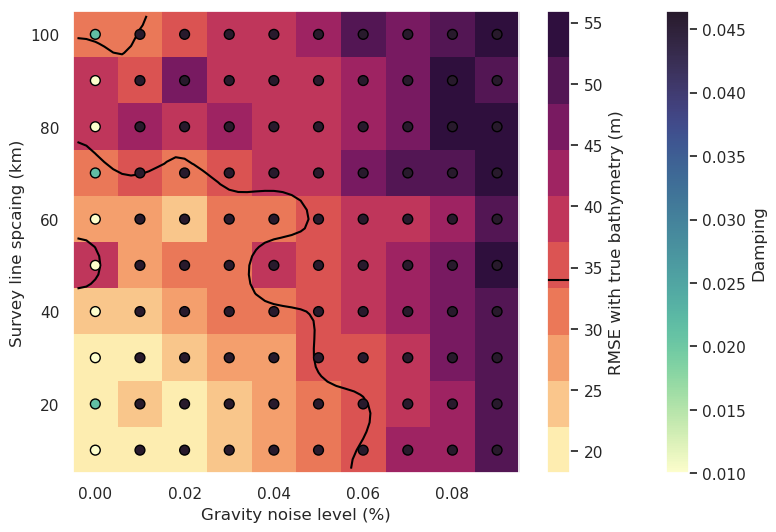

In [55]:
fig = plotting.plot_noise_spacing_ensemble(
    df,
    background="RMSE",
    background_title="RMSE with true bathymetry (m)",
    # background="Score",
    # background_title="Gravity CV score",
    # background="Damping",
    # background_title="Damping",
    # background="Eq source score",
    # background_title="Eq source score",
    # background_color_log = True,
    background_robust=True,
    # points_color=df.RMSE,
    points_color=df.Damping,
    # points_color=df["Eq source score"],
    # points_color=df.Score,
    # points_size=df.RMSE,
    # points_size=df.Score,
    # points_scaling=80,
    # points_color_log=True,
    points_robust=True,
    plot_contours=[34],
)

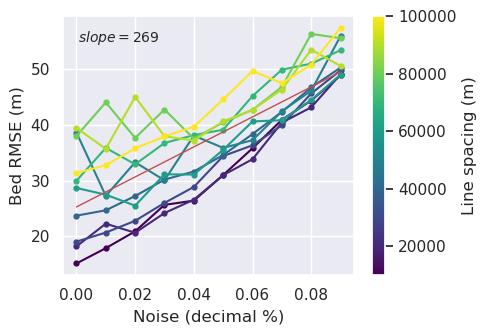

In [56]:
plotting.plot_ensemble_as_lines(
    df,
    x_col="noise",
    groupby_col="spacing",
    x_label="Noise (decimal %)",
    cbar_label="Line spacing (m)",
    trend_line=True,
)

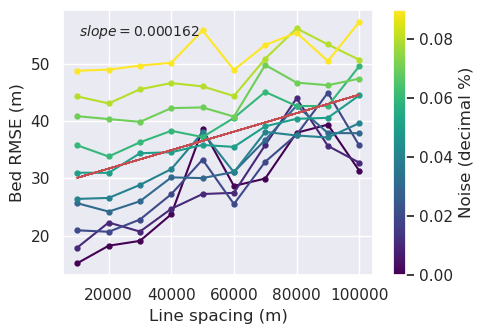

In [57]:
plotting.plot_ensemble_as_lines(
    df,
    x_col="spacing",
    groupby_col="noise",
    x_label="Line spacing (m)",
    cbar_label="Noise (decimal %)",
    trend_line=True,
)

In [ ]:
# df[(df.noise==0.0) & (df.cell_size==4000)]

In [ ]:
# choosen_result = inversion_results[df[(df.noise==0.0) & (df.cell_size==4000)].index[0]]
# choosen_result

In [ ]:
# _ = inv.inversion_RMSE(
#     results = choosen_result,
#     true_surface = bed,
#     inversion_region = inversion_region,
#     constraints = constraints,
#     plot=True,
#     # plot_type = "xarray",
#     # points_style="+.2c",
#     # robust=True,#False,
# )

In [61]:
# # indices = np.linspace(df.spacing.idxmin(), df.spacing.idxmax(), 3, dtype="int")
# # i = df[(df.noise==0) & (df.spacing==5e3)].index[0]
# # i = df[(df.noise==.09) & (df.spacing==5e3)].index[0]
# # i = df[(df.noise==.09) & (df.spacing==80e3)].index[0]
# # i = df[(df.noise==0) & (df.spacing==80e3)].index[0]
# indices = [
#     df[(df.noise == 0.09) & (df.spacing == 10e3)].index[0],
#     df[(df.noise == 0) & (df.spacing == 100e3)].index[0],
# ]

# regionals = []
# grids = []
# for i in indices:
#     print(i)

#     choosen_result = inversion_results[i]
#     print(df.loc[i])

#     print("RMSE: ", choosen_result[0])

#     ds = choosen_result[1].set_index(["northing", "easting"]).to_xarray()
#     cols = [s for s in choosen_result[1].columns.to_list() if "_layer" in s]
#     final_bed = ds[cols[-1]]

#     final_bed = final_bed.sel(
#         easting=slice(inversion_region[0], inversion_region[1]),
#         northing=slice(inversion_region[2], inversion_region[3]),
#     )
#     true_bed = bed.sel(
#         easting=slice(inversion_region[0], inversion_region[1]),
#         northing=slice(inversion_region[2], inversion_region[3]),
#     )
#     bed_dif = true_bed - final_bed
#     grids.append(bed_dif)

#     ds = choosen_result[2].set_index(["northing", "easting"]).to_xarray()
#     regionals.append(ds.reg)

90
noise                  0.090000
spacing            10000.000000
Score                  2.847739
RMSE                  48.571933
Damping                0.046416
Eq source score        0.999684
Name: 90, dtype: float64
RMSE:  48.57193288540621
9
noise                   0.000000
spacing            100000.000000
Score                   0.021383
RMSE                   32.439648
Damping                 0.010000
Eq source score         0.990704
Name: 9, dtype: float64
RMSE:  32.439648214851964


In [ ]:
# # survey_grid = anom_dfs[i][anom_dfs[i].test==False].set_index(["northing","easting"]).to_xarray().Gobs
# # survey_df = survey_dfs[i]
# # lims = utils.get_min_max(full_res_grav_grid.Gobs)

# fig = maps.plot_grd(
#     full_res_grav_grid.Gobs,
#     fig_height=10,
#     cmap="vik",
#     cpt_lims=lims,
#     title="Full resolution gravity",
#     cbar_label="mGal",
#     frame=["nSWe", "xaf10000", "yaf10000"],
#     hist=True,
#     cbar_yoffset=2,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="16p,Helvetica,black",
#     offset="j-.3/.3",
#     no_clip=True,
# )

# dif = full_res_grav_grid.Gobs - survey_grid
# fig = maps.plot_grd(
#     dif,
#     fig_height=10,
#     cmap="vik+h0",
#     title=f"RMSE: {round(inv_utils.RMSE(dif),2)} mGal",
#     cbar_label="mGal",
#     hist=True,
#     cbar_yoffset=2,
#     grd2_cpt=True,
#     fig=fig,
#     origin_shift="xshift",
#     xshift_amount=1.1,
# )

# # plot observation points
# fig.plot(survey_df[["easting", "northing"]], style="c.02c", color="black")
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="16p,Helvetica,black",
#     offset="j-.3/.3",
#     no_clip=True,
# )

# # plot the synthetic observed gravity grid
# fig = maps.plot_grd(
#     survey_grid,
#     fig_height=10,
#     cmap="vik",
#     cpt_lims=lims,
#     title="Sampled and gridded",
#     cbar_label="mGal",
#     frame=["nSwe", "xaf10000", "yaf10000"],
#     hist=True,
#     cbar_yoffset=2,
#     fig=fig,
#     origin_shift="xshift",
#     xshift_amount=1.1,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="c)",
#     font="16p,Helvetica,black",
#     offset="j-.3/.3",
#     no_clip=True,
# )
# fig.show()

# Ensemble of numbers of constraints

In [27]:
constraints_all = pd.read_csv(
    "../../synthetic_data/Ross_Sea_synthetic_constraints_semiregular.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
outer_constraints = constraints_all[constraints_all.inside==False]

grav_df = pd.read_csv(
    "../../synthetic_data/Ross_Sea_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav_df = inv_utils.prep_grav_data(
    grav_df,
    region=inversion_region,
    input_grav_name="forward_total",
    input_coord_names=("easting", "northing", "upward"),
)

regional_kwargs = dict(
    input_forward_column="bed_forward",
    input_grav_column="Gobs_shift",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    grid_method="verde",
    dampings=np.logspace(-15, -5, num=8),
    regional_method = "constraints",
)

spacings = [10e3, 20e3, 30e3, 40e3, 50e3, 60e3, 70e3, 80e3, 90e3, 100e3]
# spacings = [50e3, 100e3]

constraint_sets = []
anom_dfs = []
starting_prism_sets = []
for s in tqdm(spacings):

    inside_constraints = synthetic.constraint_layout_spacing(
        spacing = s,
        shift_stdev = 0,
        region = inversion_region,
        padding = -5e3,
        shapefile = "../../data/Ross_Sea_outline.shp",
        # plot=True,
    )
    new_constraints = pd.concat([outer_constraints, inside_constraints]).drop(
        columns=["upward", "uncert"]
    )

    # sampled the true bed values at these points
    new_constraints = profile.sample_grids(
        new_constraints, bed, "upward", coord_names=("easting", "northing")
    )

    # add gaussian noise with stdev of 5 m for all points
    new_constraints["upward"], new_constraints["uncert"] = synthetic.contaminate(
        new_constraints.upward,
        stddev=5,
        percent=False,
        seed=0,
        return_stddev=True,
    )

    # for inside points, replace with gaussian noise with a stdev of
    # 2% of each points depths
    noise, uncert = synthetic.contaminate(
        new_constraints[new_constraints.inside].upward,
        stddev=0.02,
        percent=True,
        percent_as_max_abs=False,
        seed=0,
        return_stddev=True,
    )
    new_constraints.loc[new_constraints.inside, "upward"] = noise
    new_constraints.loc[new_constraints.inside, "uncert"] = uncert

#     dampings = list(np.logspace(-20, -5, num=3))
    dampings = [10**-20]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", sp.linalg.LinAlgWarning)
        spline = inv_utils.best_SplineCV(
            coordinates = (new_constraints.easting, new_constraints.northing),
            data = new_constraints.upward,
            weights = 1/(new_constraints.uncert**2),
            dampings=dampings,
            delayed=False,
        )
    new_starting_bed = spline.grid(region=buffer_region, spacing=layer_spacing,).scalars

    # drop buffer region constraints
    new_constraints = utils.points_inside_region(
        new_constraints, inversion_region,  names=("easting", "northing")
    )

    # recreate prism layer
    bed_prisms = inv_utils.grids_to_prisms(
        surface = new_starting_bed,
        reference=np.nanmean(new_starting_bed.values),
        density=xr.where(new_starting_bed >= np.nanmean(new_starting_bed.values), density, -density),
    )

    # calculate gravity of starting bed
    bed_grav_grid, bed_grav_df = inv_utils.forward_grav_of_prismlayer(
        [bed_prisms],
        grav_df,
        names=["bed_prisms"],
        remove_median=False,
        progressbar=True,
        plot=False,
    )
    grav_df["bed_forward"] = bed_grav_df.forward_total

    bed_grav_grid, bed_grav_df = inv_utils.forward_grav_of_prismlayer(
        [bed_prisms],
        grav_df,
        names=["bed_prisms"],
        remove_median=False,
        progressbar=True,
        plot=False,
    )
    grav_df["bed_forward"] = bed_grav_df.forward_total

    # add noise
    # grav_df["Gobs"] = synthetic.contaminate(
    #     grav_df.Gobs,
    #     stddev=0.02,
    #     percent=True,
    #     seed=0,
    # )
    grav_df = inv.misfit(
        input_grav=grav_df,
        input_forward_column="bed_forward",
        input_grav_column="Gobs",
        constraints=constraints,
    )
    
    # remove regional field
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", sp.linalg.LinAlgWarning)
        df = regional.regional_seperation(
            **regional_kwargs,
            constraints=new_constraints,
            input_grav=grav_df,
            constraint_weights = 1/(new_constraints.uncert**2),
        )

    constraint_sets.append(new_constraints)
    anom_dfs.append(df)
    starting_prism_sets.append(bed_prisms)

ensemble_fname = "../../synthetic_data/Ross_Sea_ensemble/Ross_Sea_constraints_ensemble"

# save results to pickle dataframes
with open(f"{ensemble_fname}_anomalies.pickle", 'wb') as fout:
    pickle.dump(anom_dfs, fout)
with open(f"{ensemble_fname}_constraints.pickle", 'wb') as fout:
    pickle.dump(constraint_sets, fout)
with open(f"{ensemble_fname}_prisms.pickle", 'wb') as fout:
    pickle.dump(starting_prism_sets, fout)
with open(f"{ensemble_fname}_spacings.pickle", 'wb') as fout:
    pickle.dump(spacings, fout)

  0%|          | 0/2 [00:00<?, ?it/s]

Standard deviation used for noise: [5]
Highest score: 0.99546865262135
Best damping: 1e-20


  0%|                                                 | 0/19481 [00:00<?, ?it/s]

  0%|                                                 | 0/19481 [00:00<?, ?it/s]

DC shifted observed gravity by 6.22mGal to match forward gravity.
Highest score: 0.9949366636696751
Best damping: 1.9306977288832457e-11
Standard deviation used for noise: [5]
Highest score: 0.9961048871563477
Best damping: 1e-20


  0%|                                                 | 0/19481 [00:00<?, ?it/s]

  0%|                                                 | 0/19481 [00:00<?, ?it/s]

DC shifted observed gravity by 6.5mGal to match forward gravity.
Highest score: 0.9970462636912654
Best damping: 5.179474679231223e-10


In [10]:
ensemble_fname = "../../synthetic_data/Ross_Sea_ensemble/Ross_Sea_constraints_ensemble"

with open(f"{ensemble_fname}_anomalies.pickle", "rb") as f:
    anom_dfs = pickle.load(f)
with open(f"{ensemble_fname}_constraints.pickle", "rb") as f:
    constraint_sets = pickle.load(f)
with open(f"{ensemble_fname}_prisms.pickle", "rb") as f:
    starting_prism_sets = pickle.load(f)
with open(f"{ensemble_fname}_spacings.pickle", "rb") as f:
    spacings = pickle.load(f)

print(len(anom_dfs))
print(len(constraint_sets))
print(len(starting_prism_sets))
print(spacings)

10
10
10
[10000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 100000.0]


In [11]:
# i = 0
# _ = plotting.anomalies_plotting(
#     anom_dfs[i],
#     constraints=constraint_sets[i],
#     input_forward_column="bed_forward",
#     input_grav_column="Gobs_shift",
#     # plot_type="pygmt",
#     plot_type="xarray",
#     robust=False,
# )

In [12]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.15,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

dampings = np.logspace(-4, -1, 10)
# dampings = [10**-3, 10**-2.8]
print(f"Damping values: {dampings}")

ensemble_fname = "../../synthetic_data/Ross_Sea_ensemble/Ross_Sea_constraints_ensemble"

inversion_results = []
resulting_scores = []
resulting_dampings = []
resulting_rmses = []
for i, df in enumerate(tqdm(anom_dfs)):
    spacing = spacings[i]

    # set name and storage for the optimization
    set_fname = f"{ensemble_fname}_spacing_{spacing}"

    # create weights grid
    starting_prisms = starting_prism_sets[i]
    min_dist = inv_utils.normalized_mindist(
        constraint_sets[i],
        starting_prisms,
        mindist = layer_spacing/np.sqrt(2),
        low = 0,
        high = 1,
        region=inversion_region,
    )
    starting_prisms["weights"] = min_dist

    inversion_kwargs["prism_layer"] = starting_prisms

#     with inv_utils.HiddenPrints():
#         CV_scores, rmses = inv.inversion_optimal_parameters(
#             training_data= df[df.test==False],
#             testing_data = df[df.test==True],
#             parameter_values = dampings,
#             function = inv.inversion_damping_MSE,
#             inversion_region = inversion_region,
#             true_surface = bed,
#             plot = False,
#             plot_grids = False,
#             results_fname = set_fname,
#             progressbar=False,
#             **inversion_kwargs,
#         )

#     # put all scores and damping values into dict
#     CV_results = dict(CV_scores=CV_scores, dampings=dampings, rmses=rmses)

#     # remove if exists
#     pathlib.Path(f"{set_fname}.pickle").unlink(missing_ok=True)

#     # save scores and dampings of each set to pickle
#     with open(f"{set_fname}.pickle", 'wb') as f:
#         pickle.dump(CV_results, f)

    # load scores and dampings of each set of noise/sampling
    with open(f"{set_fname}.pickle", "rb") as f:
        CV_results = pickle.load(f)

    # get best parameters of each set
    best = np.argmin(CV_results["CV_scores"])
    best_score = CV_results["CV_scores"][best]
    best_rmse = CV_results["rmses"][best]
    best_damping = CV_results["dampings"][best]

    # get best inversion result of each set
    with open(f"{set_fname}_trial_{best}.pickle", "rb") as f:
        inv_result = pickle.load(f)

    inversion_results.append(inv_result)
    resulting_dampings.append(best_damping)
    resulting_scores.append(best_score)
    resulting_rmses.append(best_rmse)
    
    # delete other results to save space
    fnames = []
    for i in range(len(dampings)):
        if i == best:
            pass
        else:
            fnames.append(f"{set_fname}_trial_{i}.pickle")
    for f in fnames:
        pathlib.Path(f).unlink(missing_ok=True)      
        
df = pd.DataFrame({
    "spacing": spacings,
    "Score": resulting_scores,
    "RMSE": resulting_rmses,
    "Damping": resulting_dampings,
    "Constraints number": [len(x[x.inside]) for x in constraint_sets],
})

df.to_csv(
    f"{ensemble_fname}.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
df

Damping values: [0.0001     0.00021544 0.00046416 0.001      0.00215443 0.00464159
 0.01       0.02154435 0.04641589 0.1       ]


  0%|          | 0/10 [00:00<?, ?it/s]

,spacing,Score,RMSE,Damping,Constraints number
0,10000.0,0.079010,6.159336,0.021544,959
1,20000.0,0.039381,7.395325,0.010000,235
2,30000.0,0.042777,8.924967,0.010000,113
3,40000.0,0.015521,10.987568,0.010000,59
4,50000.0,0.032035,15.984917,0.010000,35
5,60000.0,0.050650,25.715636,0.010000,31
6,70000.0,0.045264,35.420549,0.010000,15
7,80000.0,0.033512,49.027944,0.010000,15
8,90000.0,0.029261,58.920405,0.010000,15
9,100000.0,0.045682,66.217876,0.010000,9


In [15]:
# get starting bed RMSE's

grids = []
for i, _ in enumerate(starting_prism_sets):

    choosen_result = inversion_results[i]
    # print(df.loc[i])

    consts = constraint_sets[i]
    print("num constraints: ", len(consts[consts.inside]))

    print("RMSE: ",choosen_result[0])

    ds = inversion_results[i][1].set_index(["northing","easting"]).to_xarray()
    cols = [s for s in inversion_results[i][1].columns.to_list() if "_layer" in s]
    final_bed = ds[cols[-1]]

    final_bed = final_bed.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    true_bed = bed.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    bed_dif = true_bed - final_bed
    grids.append(bed_dif)

num constraints:  959
RMSE:  6.159335720427813
num constraints:  235
RMSE:  7.395325295908511
num constraints:  113
RMSE:  8.924967163465876
num constraints:  59
RMSE:  10.987567607930185
num constraints:  35
RMSE:  15.984917030095465
num constraints:  31
RMSE:  25.715635943190613
num constraints:  15
RMSE:  35.42054862891672
num constraints:  15
RMSE:  49.027944086942796
num constraints:  15
RMSE:  58.920405023316
num constraints:  9
RMSE:  66.21787623325899


In [35]:
ensemble_fname = "../../synthetic_data/Ross_Sea_ensemble/Ross_Sea_constraints_ensemble"

df = pd.read_csv(
    f"{ensemble_fname}.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# add starting errors to dataframe
starting_errors = []
for i in inversion_results:
    ds = i[1].set_index(["northing", "easting"]).to_xarray()
    starting_bed = ds.starting_bed

    starting_bed = starting_bed.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    true_bed = bed.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )

    starting_error = true_bed - starting_bed
    starting_errors.append(utils.RMSE(starting_error))
    
df["starting_errors"] = starting_errors
df

,spacing,Score,RMSE,Damping,Constraints number,starting_errors
0,10000.0,0.079010,6.159336,0.021544,959,8.588895
1,20000.0,0.039381,7.395325,0.010000,235,13.988681
2,30000.0,0.042777,8.924967,0.010000,113,21.435350
3,40000.0,0.015521,10.987568,0.010000,59,25.571774
4,50000.0,0.032035,15.984917,0.010000,35,30.477776
5,60000.0,0.050650,25.715636,0.010000,31,42.004278
6,70000.0,0.045264,35.420549,0.010000,15,43.820521
7,80000.0,0.033512,49.027944,0.010000,15,48.497405
8,90000.0,0.029261,58.920405,0.010000,15,52.355587
9,100000.0,0.045682,66.217876,0.010000,9,55.986400


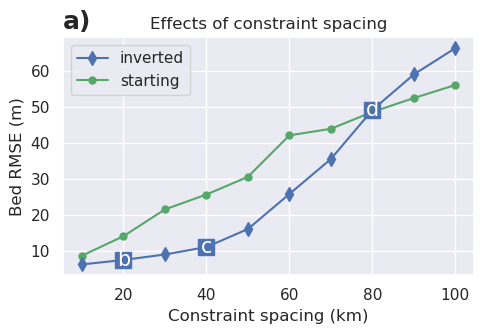

In [17]:
# indices = np.linspace(df.spacing.idxmin(), df.spacing.idxmax(), 3, dtype="int")
indices = [1, 3, 7]

plotting.plot_constraint_spacing_ensemble(
    df,
    # logy=True,
    # logx=True,
    # plot_constraints=True,
    plot_starting_error=True,
    highlight_points=indices,
    subplot_label="a)",
    # horizontal_line = 34,
)

In [36]:
# indices = np.linspace(df.spacing.idxmin(), df.spacing.idxmax(), 3, dtype="int")
indices = [1, 3, 7]

regionals = []
grids = []
true_regionals = []
for i in indices:
    print(i)

    choosen_result = inversion_results[i]
    print(df.loc[i])

    consts = constraint_sets[i]
    print("num constraints: ", len(consts[consts.inside]))

    print("RMSE: ", choosen_result[0])

    ds = choosen_result[1].set_index(["northing", "easting"]).to_xarray()
    cols = [s for s in choosen_result[1].columns.to_list() if "_layer" in s]
    final_bed = ds[cols[-1]]

    final_bed = final_bed.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    true_bed = bed.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    bed_dif = true_bed - final_bed
    grids.append(bed_dif)

    ds = choosen_result[2].set_index(["northing", "easting"]).to_xarray()
    regionals.append(ds.reg)
    true_regionals.append(ds.basement)

1
spacing               20000.000000
Score                     0.039381
RMSE                      7.395325
Damping                   0.010000
Constraints number      235.000000
starting_errors          13.988681
Name: 1, dtype: float64
num constraints:  235
RMSE:  7.395325295908511
3
spacing               40000.000000
Score                     0.015521
RMSE                     10.987568
Damping                   0.010000
Constraints number       59.000000
starting_errors          25.571774
Name: 3, dtype: float64
num constraints:  59
RMSE:  10.987567607930185
7
spacing               80000.000000
Score                     0.033512
RMSE                     49.027944
Damping                   0.010000
Constraints number       15.000000
starting_errors          48.497405
Name: 7, dtype: float64
num constraints:  15
RMSE:  49.027944086942796


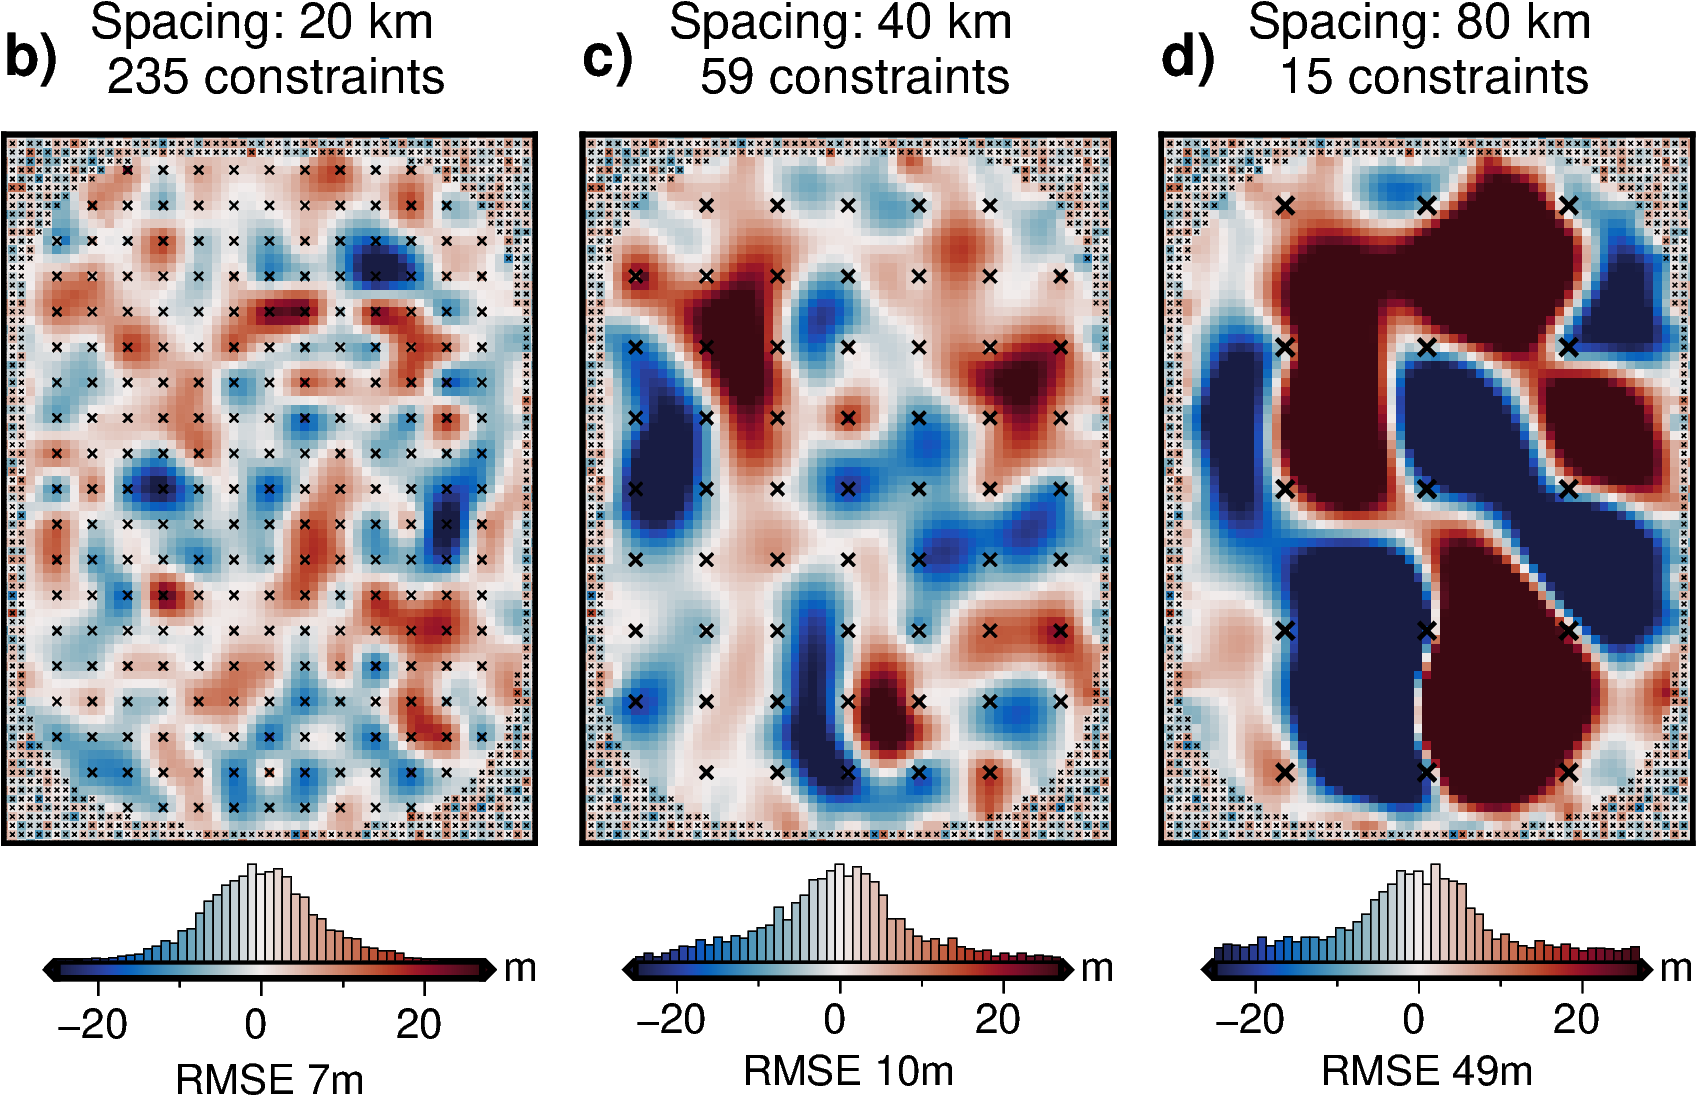

In [48]:
# set color limits
lims = [utils.get_min_max(i, robust=True) for i in grids]
# print(lims)
# # lims = [min([i[0] for i in lims]), max([i[1] for i in lims])]
# lims = [
#     utils.get_min_max([i[0] for i in lims], robust=True)[0],
#     utils.get_min_max([i[1] for i in lims], robust=True)[1]]
# use lims of middle grid
lims = lims[1]

for num, ind in enumerate(indices):
    if num == 0:
        fig = None
        origin_shift = "initialize"
        # xshift_amount = None
    else:
        fig = fig
        origin_shift = "xshift"
        # xshift_amount = 1.1

    fig = maps.plot_grd(
        grids[num],
        fig_height=6,
        title=f"Spacing: {int(df.loc[ind].spacing/1e3)} km @^ {int(df.loc[ind]['Constraints number'])} constraints",
        title_font="12p,Helvetica,black",
        cmap="balance+h0",
        cpt_lims=lims,
        cbar_label=f"RMSE {int(inv_utils.RMSE(grids[num]))}m",
        cbar_unit="m",
        hist=True,
        cbar_yoffset=1,
        hist_bin_num=50,
        origin_shift=origin_shift,
        # xshift_amount=xshift_amount,
        fig=fig,
    )
    fig.plot(
        x=constraint_sets[ind][constraint_sets[ind].inside].easting,
        y=constraint_sets[ind][constraint_sets[ind].inside].northing,
        style=f"x{.1*(1+num/2)}c",
        pen=f"{.5*(1+num/2)}p",
    )
    fig.plot(
        x=constraint_sets[ind][constraint_sets[ind].inside == False].easting,
        y=constraint_sets[ind][constraint_sets[ind].inside == False].northing,
        style="x.05c",
    )
    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[num+1]})",
        font="14p,Helvetica-Bold,black",
        offset="j0c/.5c",
        no_clip=True,
    )
fig.show()

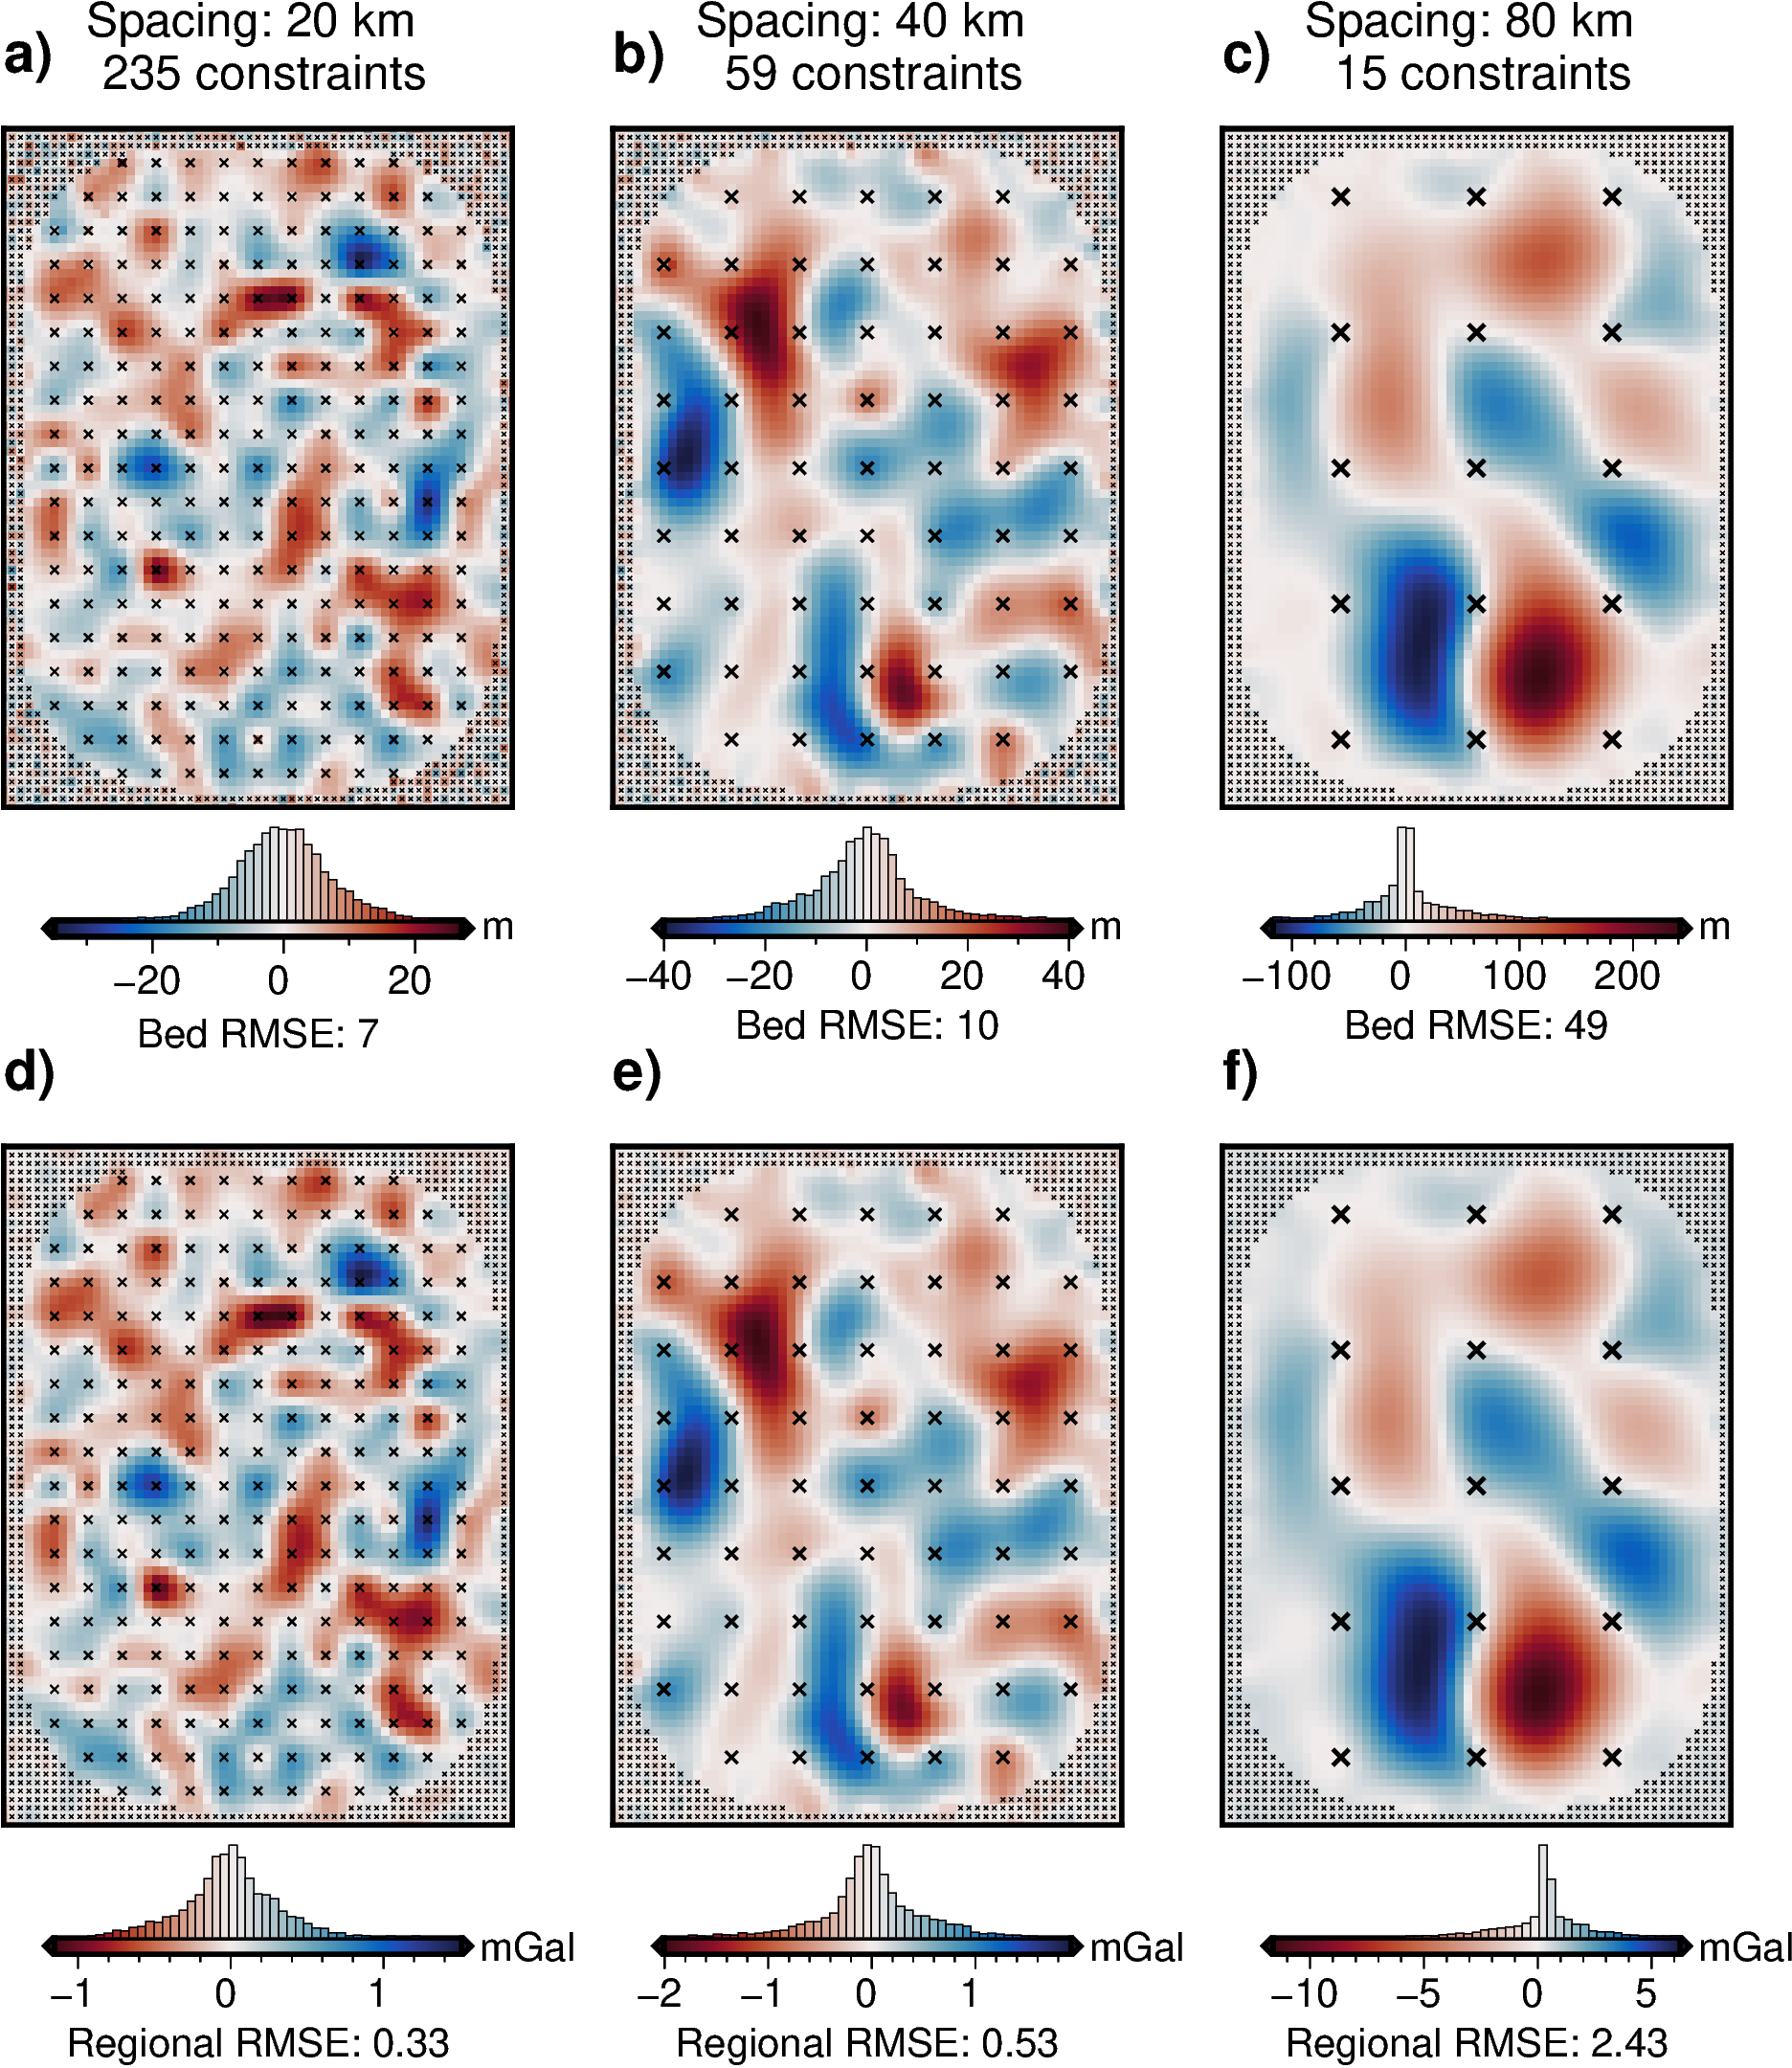

In [49]:
for num, ind in enumerate(indices):
    true_reg = true_regionals[num]
    reg_dif = true_reg - regionals[num]
    reg_dif -= np.nanmean(reg_dif)

    if num == 0:
        fig = None
        origin_shift = "initialize"
        xshift_amount = 1
        yshift_amount = 1
    else:
        fig = fig
        origin_shift = "both_shift"
        xshift_amount = 1.1
        yshift_amount = 1

    fig = maps.plot_grd(
        grids[num],
        fig_height=6,
        title=f"Spacing: {int(df.loc[ind].spacing/1e3)} km @^ {int(df.loc[ind]['Constraints number'])} constraints",
        title_font="12p,Helvetica,black",
        cmap="balance+h0",
        cbar_label=f"Bed RMSE: {int(inv_utils.RMSE(grids[num]))}",
        cbar_unit="m",
        hist=True,
        cbar_yoffset=1,
        hist_bin_num=50,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
        fig=fig,
    )
    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[num]})",
        font="14p,Helvetica-Bold,black",
        offset="j0c/.5c",
        no_clip=True,
    )
    fig.plot(
        x=constraint_sets[ind][constraint_sets[ind].inside].easting,
        y=constraint_sets[ind][constraint_sets[ind].inside].northing,
        style=f"x{.1*(1+num/2)}c",
        pen=f"{.5*(1+num/2)}p",
    )
    fig.plot(
        x=constraint_sets[ind][constraint_sets[ind].inside == False].easting,
        y=constraint_sets[ind][constraint_sets[ind].inside == False].northing,
        style="x.05c",
    )
    fig = maps.plot_grd(
        reg_dif,
        fig_height=6,
        reverse_cpt=True,
        points=constraint_sets[ind][constraint_sets[ind].inside].rename(
            columns={"easting": "x", "northing": "y"}
        ),
        points_style=f"x{.1*(1+num/2)}c",
        points_pen=f"{.5*(1+num/2)}p",
        cmap="balance+h0",
        cbar_label=f"Regional RMSE: {round(inv_utils.RMSE(reg_dif),2)}",
        cbar_unit="mGal",
        hist=True,
        cbar_yoffset=1,
        hist_bin_num=50,
        origin_shift="both_shift",
        xshift_amount=0,
        yshift_amount=-1,
        fig=fig,
    )

    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[num+3]})",
        font="14p,Helvetica-Bold,black",
        offset="j0c/.5c",
        no_clip=True,
    )
    fig.plot(
        x=constraint_sets[ind][constraint_sets[ind].inside == False].easting,
        y=constraint_sets[ind][constraint_sets[ind].inside == False].northing,
        style="x.05c",
    )

fig.show()

In [50]:
# # weights as RMSE of final inversion gravity misfit
# # grav_dfs = [i[2] for i in inversion_results]
# # weights = [utils.RMSE(df[list(df.columns)[-1]]) for df in grav_dfs]
# # weights as RMS bed error
# weights = [i[0] for i in inversion_results]
# weights = [1/(w**2) for w in weights]

# topo_dfs = [i[1] for i in inversion_results]
# topos = [df.set_index(["northing", "easting"]).to_xarray()[list(df.columns)[-1]] for df in topo_dfs]
# topos = [t.rename(f"run_{i}") for i,t in enumerate(topos)]
# topos_ds = xr.merge(topos)
# stats = inv_utils.model_ensemble_stats(topos_ds, weights = weights)
# merged, z_mean, z_stdev, weighted_mean, weighted_stdev, z_min, z_max = stats

# grids = [
#         z_mean, z_stdev, z_min,
#         weighted_mean, weighted_stdev, z_max,
#     ]

# grids = [
#         utils.mask_from_shp(shapefile="../data/Ross_Sea_outline.shp", xr_grid = i, masked=True, invert=False)
#         for i in grids]

# subplot_titles = [
#         "z_mean", "z_stdev", "z_min",
#         "weighted_mean", "weighted_stdev", "z_max",
#     ]

# fig = maps.subplots(
#     grids = grids,
#     region = inversion_region,
#     dims = (2, 3),
#     fig_title = "Density Monte Carlo results",
#     subplot_titles = subplot_titles,
#     cbar_labels = ["m" for x in grids],
#     autolabel = "a)+JTL",
#     fig_height = 10,
#     margins = "1c",
#     # grd2cpt=True,
#     cmaps = ["rain", "inferno", "rain",
#              "rain", "inferno", "rain",],
#     reverse_cpt=True,
#     # hist=True,
#     # cbar_yoffset=1.5,
# )
# fig.show()